In [1]:
%config Completer.use_jedi = False

import configparser
config = configparser.ConfigParser()
config.read('agg-config.txt')


time_step = int(config.get('Configuration', 'time_step'))
time_step2 = int(config.get('Configuration', 'time_step2'))

window_size = int(config.get('Configuration', 'window_size'))
processed_data_folder = config.get('Configuration', 'processed_data_folder')
raw_data_folder = config.get('Configuration', 'raw_data_folder')

ini_date = config.get('Configuration', 'ini_date')
end_date = config.get('Configuration', 'end_date')

users=config.get('Configuration', 'users')
users = [(item.strip()) for item in users.split(',')]
activities=config.get('Configuration', 'activities')
activities = [(item.strip()) for item in activities.split(',')]

w = int(config.get('Configuration', 'w'))
h = int(config.get('Configuration', 'h'))

user_color={}
for user in users:
    user_color[user]=config.get('Colors', user)
print(user_color)

{'ed9c': 'green', '0001': 'blue', '3d57': 'red'}


In [2]:
import numpy as np
from pandas import read_csv    
import pandas as pd
import time

from datetime import datetime

off_zone=60*60*2

def day_time(ti):
    return int((int)((ti+off_zone)/(60*60*24)))


def time2str(tt):
    return datetime.fromtimestamp(tt).strftime("%Y-%m-%d %H:%M:%S")

tN = (int)(datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S').timestamp())
print (end_date,"End date is", tN, "day:",day_time(tN), time2str(tN))


print(ini_date)
t0 = (int)(datetime.strptime(ini_date, '%Y-%m-%d %H:%M:%S').timestamp())
print (ini_date,"Init date is", t0, "day:",day_time(t0), time2str(t0))




def day_time0(ti):
    return day_time(ti)-day_time(t0)+1

def relT(ti):
    return (int)((ti-t0)/time_step)

def sizeT():
    return relT(tN) 

day=list(range(day_time(t0),day_time(tN)+1))[0]


2024-07-8 01:59:59 End date is 1720396799 day: 19912 2024-07-08 01:59:59
2024-07-7 02:00:00
2024-07-7 02:00:00 Init date is 1720310400 day: 19911 2024-07-07 02:00:00


In [3]:
import os
from PIL import Image 
import cv2

def getGTImg(tt,user):
    file_path = os.path.join(processed_data_folder+"DAY_"+str(day)+"/"+user+"_agg/FP."+str(tt)+".png")
    if os.path.exists(file_path):
        return rescale_image(np.array(Image.open(file_path)),8) / 255.0
    else:
        return None
    
#def getAREAactivity(user,activity):
#    file_path = os.path.join(processed_data_folder+"DAY_"+str(day)+"/"+user+"."+str(activity)+".png")
    #print(file_path)
#    if os.path.exists(file_path):
#        return np.array(Image.open(file_path)) / 255.0
#    else:
#        return None
    
def rescale_image(image, scale_factor):
    width = int(image.shape[1] * scale_factor)
    height = int(image.shape[0] * scale_factor)
    dimensions = (width, height)
    rescaled_image = cv2.resize(image, dimensions, interpolation=cv2.INTER_LINEAR)
    return rescaled_image

In [4]:
def append_socialisation_degree(user1,user2,tt,degree):
    file_path = os.path.join(processed_data_folder+"DAY_"+str(day)+"/"+user1+"."+user2+".tsv")
    print(file_path)
    with open(file_path, 'a') as file:
        file.write(tt+"\t"+degree+"\n")

In [5]:
def delete_file_if_exists(file_path):
    if os.path.exists(file_path):
        os.remove(file_path)
        print("Deleted file: ",{file_path})
    else:
        print("File does not exist: ",file_path)

In [6]:
def normalize_image(tt, user, last_img):
    img = getGTImg(tt, user)
    if img is not None:
        A_min = np.min(img)
        A_max = np.max(img)
        if A_max < 0.05:
            print(f"\t zero image for {user}")
            img = last_img
        else:
            last_img = img
            img = (img - A_min) / (A_max - A_min)
        
        print(user, tt, A_min, A_max, img.shape)
    return img, last_img

In [7]:
ts=list(range(t0+time_step2,tN-time_step2,time_step2))

user_activity={}
for user in users:
    print(user)
    user_activity[user]={}
    for tx,tt in enumerate(ts):
        user_activity[user][tt]="IDLE"
    for ax,activity in enumerate(activities):
        print(user,activity)
        df_total=read_csv(processed_data_folder+"/DAY_"+str(day)+"/act/INTERVAL."+user+"."+activity+".tsv", sep="\t",parse_dates=True, header=None, names=["ix","d0","dN"])
        try:
            print(len(df_total))
            #print(df_total['d0'])
            print(pd.to_datetime(df_total['d0'], format='%Y-%m-%d %H:%M:%S', errors='coerce'))
            print(pd.to_datetime(df_total['dN'], format='%Y-%m-%d %H:%M:%S', errors='coerce'))
            df_total['d0'] = pd.to_datetime(df_total['d0'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
            df_total['dN'] = pd.to_datetime(df_total['dN'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
            #print(df_total)
            
            for tx,tt in enumerate(ts):
                ttt=pd.to_datetime(time2str(tt))
                #print(ttt,"vs",df_total['d0'],df_total['dN'])
                row = df_total[(df_total['d0'] <= ttt) & (df_total['dN'] >= ttt)]
                
                if(row.size>0):
                    print(ttt,"df_in#tervalo",activity)
                    user_activity[user][tt]=activity
                #else:
                #    act="IDLE"
                #print("\t label:",act,ttt)
                #user_activity[user][tt]=act
        except Exception as e:
            print("None activity", activity)

    #print(user_activity[user])
#print(activities)


ed9c
ed9c cooking
4
0   2024-07-07 14:30:00
1   2024-07-07 17:50:00
2   2024-07-07 21:47:00
3   2024-07-08 00:34:00
Name: d0, dtype: datetime64[ns]
0   2024-07-07 14:53:00
1   2024-07-07 17:51:00
2   2024-07-07 21:47:00
3   2024-07-08 00:35:00
Name: dN, dtype: datetime64[ns]
2024-07-07 14:30:00 df_in#tervalo cooking
2024-07-07 14:31:00 df_in#tervalo cooking
2024-07-07 14:32:00 df_in#tervalo cooking
2024-07-07 14:33:00 df_in#tervalo cooking
2024-07-07 14:34:00 df_in#tervalo cooking
2024-07-07 14:35:00 df_in#tervalo cooking
2024-07-07 14:36:00 df_in#tervalo cooking
2024-07-07 14:37:00 df_in#tervalo cooking
2024-07-07 14:38:00 df_in#tervalo cooking
2024-07-07 14:39:00 df_in#tervalo cooking
2024-07-07 14:40:00 df_in#tervalo cooking
2024-07-07 14:41:00 df_in#tervalo cooking
2024-07-07 14:42:00 df_in#tervalo cooking
2024-07-07 14:43:00 df_in#tervalo cooking
2024-07-07 14:44:00 df_in#tervalo cooking
2024-07-07 14:45:00 df_in#tervalo cooking
2024-07-07 14:46:00 df_in#tervalo cooking
2024-07-07

2024-07-07 12:32:00 df_in#tervalo pc
2024-07-07 12:33:00 df_in#tervalo pc
2024-07-07 12:34:00 df_in#tervalo pc
2024-07-07 12:35:00 df_in#tervalo pc
2024-07-07 12:36:00 df_in#tervalo pc
2024-07-07 12:37:00 df_in#tervalo pc
2024-07-07 12:38:00 df_in#tervalo pc
2024-07-07 12:39:00 df_in#tervalo pc
2024-07-07 12:40:00 df_in#tervalo pc
2024-07-07 12:41:00 df_in#tervalo pc
2024-07-07 12:42:00 df_in#tervalo pc
2024-07-07 12:43:00 df_in#tervalo pc
2024-07-07 12:44:00 df_in#tervalo pc
2024-07-07 12:45:00 df_in#tervalo pc
2024-07-07 12:46:00 df_in#tervalo pc
2024-07-07 12:47:00 df_in#tervalo pc
2024-07-07 12:48:00 df_in#tervalo pc
2024-07-07 12:49:00 df_in#tervalo pc
2024-07-07 12:50:00 df_in#tervalo pc
2024-07-07 12:51:00 df_in#tervalo pc
2024-07-07 12:52:00 df_in#tervalo pc
2024-07-07 12:53:00 df_in#tervalo pc
2024-07-07 12:54:00 df_in#tervalo pc
2024-07-07 12:55:00 df_in#tervalo pc
2024-07-07 12:56:00 df_in#tervalo pc
2024-07-07 12:57:00 df_in#tervalo pc
2024-07-07 12:58:00 df_in#tervalo pc
2

2024-07-07 15:20:00 df_in#tervalo sleep
2024-07-07 15:21:00 df_in#tervalo sleep
2024-07-07 15:22:00 df_in#tervalo sleep
2024-07-07 15:23:00 df_in#tervalo sleep
2024-07-07 15:24:00 df_in#tervalo sleep
2024-07-07 15:25:00 df_in#tervalo sleep
2024-07-07 15:26:00 df_in#tervalo sleep
2024-07-07 15:27:00 df_in#tervalo sleep
2024-07-07 15:28:00 df_in#tervalo sleep
2024-07-07 15:29:00 df_in#tervalo sleep
2024-07-07 15:30:00 df_in#tervalo sleep
2024-07-07 15:31:00 df_in#tervalo sleep
2024-07-07 15:32:00 df_in#tervalo sleep
2024-07-07 15:33:00 df_in#tervalo sleep
2024-07-07 15:34:00 df_in#tervalo sleep
2024-07-07 15:35:00 df_in#tervalo sleep
2024-07-07 15:36:00 df_in#tervalo sleep
2024-07-07 15:37:00 df_in#tervalo sleep
2024-07-07 15:38:00 df_in#tervalo sleep
2024-07-07 15:39:00 df_in#tervalo sleep
2024-07-07 15:40:00 df_in#tervalo sleep
2024-07-07 15:41:00 df_in#tervalo sleep
2024-07-07 15:42:00 df_in#tervalo sleep
2024-07-07 15:43:00 df_in#tervalo sleep
2024-07-07 15:44:00 df_in#tervalo sleep


2024-07-07 12:33:00 df_in#tervalo cooking
2024-07-07 12:34:00 df_in#tervalo cooking
2024-07-07 12:44:00 df_in#tervalo cooking
2024-07-07 12:45:00 df_in#tervalo cooking
2024-07-07 13:35:00 df_in#tervalo cooking
2024-07-07 13:39:00 df_in#tervalo cooking
2024-07-07 13:40:00 df_in#tervalo cooking
2024-07-07 13:45:00 df_in#tervalo cooking
2024-07-07 13:46:00 df_in#tervalo cooking
2024-07-07 13:47:00 df_in#tervalo cooking
2024-07-07 13:48:00 df_in#tervalo cooking
2024-07-07 13:49:00 df_in#tervalo cooking
2024-07-07 13:50:00 df_in#tervalo cooking
2024-07-07 13:51:00 df_in#tervalo cooking
2024-07-07 13:52:00 df_in#tervalo cooking
2024-07-07 13:53:00 df_in#tervalo cooking
2024-07-07 13:54:00 df_in#tervalo cooking
2024-07-07 13:55:00 df_in#tervalo cooking
2024-07-07 13:56:00 df_in#tervalo cooking
2024-07-07 13:57:00 df_in#tervalo cooking
2024-07-07 13:58:00 df_in#tervalo cooking
2024-07-07 13:59:00 df_in#tervalo cooking
2024-07-07 14:00:00 df_in#tervalo cooking
2024-07-07 14:01:00 df_in#tervalo 

0001 pc
0
Series([], Name: d0, dtype: datetime64[ns])
Series([], Name: dN, dtype: datetime64[ns])
0001 sleep
0
Series([], Name: d0, dtype: datetime64[ns])
Series([], Name: dN, dtype: datetime64[ns])
0001 kitchen
25
0    2024-07-07 02:37:00
1    2024-07-07 02:39:00
2    2024-07-07 02:46:00
3    2024-07-07 03:00:00
4    2024-07-07 12:25:00
5    2024-07-07 12:35:00
6    2024-07-07 12:38:00
7    2024-07-07 13:23:00
8    2024-07-07 13:41:00
9    2024-07-07 14:02:00
10   2024-07-07 14:18:00
11   2024-07-07 15:44:00
12   2024-07-07 15:57:00
13   2024-07-07 16:03:00
14   2024-07-07 19:08:00
15   2024-07-07 19:24:00
16   2024-07-07 20:23:00
17   2024-07-07 21:23:00
18   2024-07-07 21:31:00
19   2024-07-07 21:35:00
20   2024-07-07 21:48:00
21   2024-07-07 22:00:00
22   2024-07-07 22:15:00
23   2024-07-07 22:23:00
24   2024-07-07 22:35:00
Name: d0, dtype: datetime64[ns]
0    2024-07-07 02:37:00
1    2024-07-07 02:41:00
2    2024-07-07 02:53:00
3    2024-07-07 03:02:00
4    2024-07-07 12:32:00
5  

2024-07-07 12:46:00 df_in#tervalo resting
2024-07-07 12:47:00 df_in#tervalo resting
2024-07-07 12:48:00 df_in#tervalo resting
2024-07-07 12:49:00 df_in#tervalo resting
2024-07-07 12:50:00 df_in#tervalo resting
2024-07-07 12:51:00 df_in#tervalo resting
2024-07-07 12:52:00 df_in#tervalo resting
2024-07-07 12:53:00 df_in#tervalo resting
2024-07-07 12:54:00 df_in#tervalo resting
2024-07-07 12:55:00 df_in#tervalo resting
2024-07-07 12:56:00 df_in#tervalo resting
2024-07-07 12:57:00 df_in#tervalo resting
2024-07-07 12:58:00 df_in#tervalo resting
2024-07-07 12:59:00 df_in#tervalo resting
2024-07-07 13:00:00 df_in#tervalo resting
2024-07-07 13:01:00 df_in#tervalo resting
2024-07-07 13:02:00 df_in#tervalo resting
2024-07-07 13:03:00 df_in#tervalo resting
2024-07-07 13:04:00 df_in#tervalo resting
2024-07-07 13:05:00 df_in#tervalo resting
2024-07-07 13:06:00 df_in#tervalo resting
2024-07-07 13:07:00 df_in#tervalo resting
2024-07-07 13:08:00 df_in#tervalo resting
2024-07-07 13:09:00 df_in#tervalo 

2024-07-07 19:07:00 df_in#tervalo resting
2024-07-07 19:42:00 df_in#tervalo resting
2024-07-07 19:43:00 df_in#tervalo resting
2024-07-07 19:44:00 df_in#tervalo resting
2024-07-07 19:45:00 df_in#tervalo resting
2024-07-07 19:46:00 df_in#tervalo resting
2024-07-07 19:47:00 df_in#tervalo resting
2024-07-07 19:48:00 df_in#tervalo resting
2024-07-07 19:49:00 df_in#tervalo resting
2024-07-07 19:50:00 df_in#tervalo resting
2024-07-07 19:51:00 df_in#tervalo resting
2024-07-07 19:52:00 df_in#tervalo resting
2024-07-07 19:53:00 df_in#tervalo resting
2024-07-07 19:54:00 df_in#tervalo resting
2024-07-07 19:55:00 df_in#tervalo resting
2024-07-07 19:56:00 df_in#tervalo resting
2024-07-07 19:57:00 df_in#tervalo resting
2024-07-07 19:58:00 df_in#tervalo resting
2024-07-07 19:59:00 df_in#tervalo resting
2024-07-07 20:00:00 df_in#tervalo resting
2024-07-07 20:01:00 df_in#tervalo resting
2024-07-07 20:02:00 df_in#tervalo resting
2024-07-07 20:03:00 df_in#tervalo resting
2024-07-07 20:04:00 df_in#tervalo 

2024-07-08 01:43:00 df_in#tervalo resting
2024-07-08 01:44:00 df_in#tervalo resting
2024-07-08 01:45:00 df_in#tervalo resting
2024-07-08 01:46:00 df_in#tervalo resting
2024-07-08 01:47:00 df_in#tervalo resting
2024-07-08 01:48:00 df_in#tervalo resting
2024-07-08 01:49:00 df_in#tervalo resting
2024-07-08 01:50:00 df_in#tervalo resting
2024-07-08 01:51:00 df_in#tervalo resting
2024-07-08 01:52:00 df_in#tervalo resting
2024-07-08 01:53:00 df_in#tervalo resting
2024-07-08 01:54:00 df_in#tervalo resting
2024-07-08 01:55:00 df_in#tervalo resting
2024-07-08 01:56:00 df_in#tervalo resting
2024-07-08 01:57:00 df_in#tervalo resting
2024-07-08 01:58:00 df_in#tervalo resting
0001 exit
1
0   2024-07-07 03:08:00
Name: d0, dtype: datetime64[ns]
0   2024-07-07 12:16:00
Name: dN, dtype: datetime64[ns]
2024-07-07 03:08:00 df_in#tervalo exit
2024-07-07 03:09:00 df_in#tervalo exit
2024-07-07 03:10:00 df_in#tervalo exit
2024-07-07 03:11:00 df_in#tervalo exit
2024-07-07 03:12:00 df_in#tervalo exit
2024-07-0

2024-07-07 07:42:00 df_in#tervalo exit
2024-07-07 07:43:00 df_in#tervalo exit
2024-07-07 07:44:00 df_in#tervalo exit
2024-07-07 07:45:00 df_in#tervalo exit
2024-07-07 07:46:00 df_in#tervalo exit
2024-07-07 07:47:00 df_in#tervalo exit
2024-07-07 07:48:00 df_in#tervalo exit
2024-07-07 07:49:00 df_in#tervalo exit
2024-07-07 07:50:00 df_in#tervalo exit
2024-07-07 07:51:00 df_in#tervalo exit
2024-07-07 07:52:00 df_in#tervalo exit
2024-07-07 07:53:00 df_in#tervalo exit
2024-07-07 07:54:00 df_in#tervalo exit
2024-07-07 07:55:00 df_in#tervalo exit
2024-07-07 07:56:00 df_in#tervalo exit
2024-07-07 07:57:00 df_in#tervalo exit
2024-07-07 07:58:00 df_in#tervalo exit
2024-07-07 07:59:00 df_in#tervalo exit
2024-07-07 08:00:00 df_in#tervalo exit
2024-07-07 08:01:00 df_in#tervalo exit
2024-07-07 08:02:00 df_in#tervalo exit
2024-07-07 08:03:00 df_in#tervalo exit
2024-07-07 08:04:00 df_in#tervalo exit
2024-07-07 08:05:00 df_in#tervalo exit
2024-07-07 08:06:00 df_in#tervalo exit
2024-07-07 08:07:00 df_in

3d57
3d57 cooking
7
0   2024-07-07 08:08:00
1   2024-07-07 10:03:00
2   2024-07-07 14:02:00
3   2024-07-07 14:32:00
4   2024-07-07 14:57:00
5   2024-07-07 18:38:00
6   2024-07-07 21:44:00
Name: d0, dtype: datetime64[ns]
0   2024-07-07 08:08:00
1   2024-07-07 10:05:00
2   2024-07-07 14:02:00
3   2024-07-07 14:53:00
4   2024-07-07 14:57:00
5   2024-07-07 18:38:00
6   2024-07-07 21:44:00
Name: dN, dtype: datetime64[ns]
2024-07-07 08:08:00 df_in#tervalo cooking
2024-07-07 10:03:00 df_in#tervalo cooking
2024-07-07 10:04:00 df_in#tervalo cooking
2024-07-07 10:05:00 df_in#tervalo cooking
2024-07-07 14:02:00 df_in#tervalo cooking
2024-07-07 14:32:00 df_in#tervalo cooking
2024-07-07 14:33:00 df_in#tervalo cooking
2024-07-07 14:34:00 df_in#tervalo cooking
2024-07-07 14:35:00 df_in#tervalo cooking
2024-07-07 14:36:00 df_in#tervalo cooking
2024-07-07 14:37:00 df_in#tervalo cooking
2024-07-07 14:38:00 df_in#tervalo cooking
2024-07-07 14:39:00 df_in#tervalo cooking
2024-07-07 14:40:00 df_in#tervalo 

2024-07-08 00:52:00 df_in#tervalo sleep
2024-07-08 00:53:00 df_in#tervalo sleep
2024-07-08 00:54:00 df_in#tervalo sleep
2024-07-08 00:55:00 df_in#tervalo sleep
2024-07-08 00:56:00 df_in#tervalo sleep
2024-07-08 00:57:00 df_in#tervalo sleep
2024-07-08 00:58:00 df_in#tervalo sleep
2024-07-08 00:59:00 df_in#tervalo sleep
2024-07-08 01:00:00 df_in#tervalo sleep
2024-07-08 01:01:00 df_in#tervalo sleep
2024-07-08 01:02:00 df_in#tervalo sleep
2024-07-08 01:03:00 df_in#tervalo sleep
2024-07-08 01:04:00 df_in#tervalo sleep
2024-07-08 01:05:00 df_in#tervalo sleep
2024-07-08 01:06:00 df_in#tervalo sleep
2024-07-08 01:07:00 df_in#tervalo sleep
2024-07-08 01:08:00 df_in#tervalo sleep
2024-07-08 01:09:00 df_in#tervalo sleep
2024-07-08 01:10:00 df_in#tervalo sleep
2024-07-08 01:11:00 df_in#tervalo sleep
2024-07-08 01:12:00 df_in#tervalo sleep
2024-07-08 01:13:00 df_in#tervalo sleep
2024-07-08 01:14:00 df_in#tervalo sleep
2024-07-08 01:15:00 df_in#tervalo sleep
2024-07-08 01:16:00 df_in#tervalo sleep


2024-07-07 14:31:00 df_in#tervalo resting
2024-07-07 14:58:00 df_in#tervalo resting
2024-07-07 14:59:00 df_in#tervalo resting
2024-07-07 15:00:00 df_in#tervalo resting
2024-07-07 15:01:00 df_in#tervalo resting
2024-07-07 15:02:00 df_in#tervalo resting
2024-07-07 15:03:00 df_in#tervalo resting
2024-07-07 15:04:00 df_in#tervalo resting
2024-07-07 15:05:00 df_in#tervalo resting
2024-07-07 15:06:00 df_in#tervalo resting
2024-07-07 15:07:00 df_in#tervalo resting
2024-07-07 15:08:00 df_in#tervalo resting
2024-07-07 15:09:00 df_in#tervalo resting
2024-07-07 15:10:00 df_in#tervalo resting
2024-07-07 15:11:00 df_in#tervalo resting
2024-07-07 15:12:00 df_in#tervalo resting
2024-07-07 15:13:00 df_in#tervalo resting
2024-07-07 15:14:00 df_in#tervalo resting
2024-07-07 15:15:00 df_in#tervalo resting
2024-07-07 15:16:00 df_in#tervalo resting
2024-07-07 15:17:00 df_in#tervalo resting
2024-07-07 15:18:00 df_in#tervalo resting
2024-07-07 15:19:00 df_in#tervalo resting
2024-07-07 15:20:00 df_in#tervalo 

2024-07-07 21:37:00 df_in#tervalo resting
2024-07-07 21:38:00 df_in#tervalo resting
2024-07-07 21:39:00 df_in#tervalo resting
2024-07-07 21:40:00 df_in#tervalo resting
2024-07-07 21:41:00 df_in#tervalo resting
2024-07-07 21:42:00 df_in#tervalo resting
2024-07-07 21:43:00 df_in#tervalo resting
2024-07-07 21:45:00 df_in#tervalo resting
2024-07-07 21:46:00 df_in#tervalo resting
2024-07-07 21:47:00 df_in#tervalo resting
2024-07-07 21:48:00 df_in#tervalo resting
2024-07-07 21:49:00 df_in#tervalo resting
2024-07-07 21:50:00 df_in#tervalo resting
2024-07-07 21:51:00 df_in#tervalo resting
2024-07-07 21:52:00 df_in#tervalo resting
2024-07-07 21:53:00 df_in#tervalo resting
2024-07-07 21:54:00 df_in#tervalo resting
2024-07-07 21:55:00 df_in#tervalo resting
2024-07-07 21:56:00 df_in#tervalo resting
2024-07-07 21:57:00 df_in#tervalo resting
2024-07-07 21:58:00 df_in#tervalo resting
2024-07-07 21:59:00 df_in#tervalo resting
2024-07-07 22:00:00 df_in#tervalo resting
2024-07-07 22:01:00 df_in#tervalo 

2024-07-07 18:42:00 df_in#tervalo exit
2024-07-07 18:43:00 df_in#tervalo exit
2024-07-07 18:44:00 df_in#tervalo exit
2024-07-07 18:45:00 df_in#tervalo exit
2024-07-07 18:46:00 df_in#tervalo exit
2024-07-07 18:47:00 df_in#tervalo exit
2024-07-07 18:48:00 df_in#tervalo exit
2024-07-07 18:49:00 df_in#tervalo exit
2024-07-07 18:50:00 df_in#tervalo exit
2024-07-07 18:51:00 df_in#tervalo exit
2024-07-07 18:52:00 df_in#tervalo exit
2024-07-07 18:53:00 df_in#tervalo exit
2024-07-07 18:54:00 df_in#tervalo exit
2024-07-07 18:55:00 df_in#tervalo exit
2024-07-07 18:56:00 df_in#tervalo exit
2024-07-07 18:57:00 df_in#tervalo exit
2024-07-07 18:58:00 df_in#tervalo exit
2024-07-07 18:59:00 df_in#tervalo exit
2024-07-07 19:00:00 df_in#tervalo exit
2024-07-07 19:01:00 df_in#tervalo exit
2024-07-07 19:02:00 df_in#tervalo exit
2024-07-07 19:03:00 df_in#tervalo exit
2024-07-07 19:04:00 df_in#tervalo exit
2024-07-07 19:05:00 df_in#tervalo exit
2024-07-07 19:06:00 df_in#tervalo exit
2024-07-07 19:07:00 df_in

In [8]:
from itertools import combinations

pairs = combinations(users, 2)

for pair in pairs:
    print(pair[0], pair[1])
    
    delete_file_if_exists(os.path.join(processed_data_folder+"DAY_"+str(day)+"/"+str(pair[0])+"."+str(pair[1])+".tsv"))
    
    lastImg1 = np.zeros((h * 8, w * 8))
    lastImg2 = np.zeros((h * 8, w * 8))
    lastCumulativeImg = np.zeros((h * 8, w * 8))
    
    for tt in range(t0 + time_step2, tN - time_step2, time_step2):
        
        
        if(user_activity[pair[0]][tt]=="exit" or user_activity[pair[1]][tt]=="exit"):
            print(tt,"EXIT")
            social_degree=0
        else:
        
            imgUser1, lastImg1 = normalize_image(tt, pair[0], lastImg1)
            imgUser2, lastImg2 = normalize_image(tt, pair[1], lastImg2)

            social_degree = np.max(np.minimum(imgUser1, imgUser2))
            lastCumulativeImg = lastCumulativeImg + np.minimum(imgUser1, imgUser2)
  
        timestamp=pd.to_datetime(time2str(tt))
        append_socialisation_degree(pair[0],pair[1],str(timestamp),str(social_degree))
        
        
        
    if lastCumulativeImg is not None:
        A_min = np.min(lastCumulativeImg)
        A_max = np.max(lastCumulativeImg)
        
        if A_max != A_min:  # Avoid zero division
            lastCumulativeImg = (lastCumulativeImg - A_min) / (A_max - A_min)
            exponent = 0.5
            lastCumulativeImg = np.power(lastCumulativeImg, exponent)
        
    cv2.imwrite(os.path.join(processed_data_folder, "DAY_" + str(day), str(pair[0]) + "." + str(pair[1]) + ".png"), lastCumulativeImg*255)
    print("fin")
            

ed9c 0001
Deleted file:  {'./data-har/DAY_19911/ed9c.0001.tsv'}
ed9c 1720310460 0.0 0.7450980392156863 (144, 176)
0001 1720310460 0.0 0.6431372549019608 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720310520 0.0 0.8235294117647058 (144, 176)
0001 1720310520 0.0 0.6078431372549019 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720310580 0.0 0.7803921568627451 (144, 176)
0001 1720310580 0.0 0.6745098039215687 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720310640 0.0 0.7333333333333333 (144, 176)
0001 1720310640 0.0 0.6470588235294118 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720310700 0.0 0.8313725490196079 (144, 176)
0001 1720310700 0.0 0.7686274509803922 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720310760 0.0 0.8352941176470589 (144, 176)
0001 1720310760 0.0 0.788235294117647 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720310820 0.0 0.7490196078431373 (144, 176)
0001 1720310820 0.0 0.7568627450980392 (144, 176)
./data-har/DAY_19911/ed9c.0

1720314660 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720314720 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720314780 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720314840 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720314900 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720314960 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720315020 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720315080 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720315140 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720315200 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720315260 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720315320 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720315380 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720315440 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720315500 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720315560 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720315620 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720315680 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720315740 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720315800 EXIT
./data-har/DAY_

1720332300 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720332360 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720332420 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720332480 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720332540 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720332600 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720332660 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720332720 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720332780 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720332840 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720332900 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720332960 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720333020 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720333080 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720333140 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720333200 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720333260 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720333320 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720333380 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720333440 EXIT
./data-har/DAY_

0001 1720348080 0.0 0.8392156862745098 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720348140 0.0 0.9333333333333333 (144, 176)
0001 1720348140 0.0 0.7372549019607844 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720348200 0.0 0.9215686274509803 (144, 176)
0001 1720348200 0.0 0.8862745098039215 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720348260 0.0 0.9019607843137255 (144, 176)
0001 1720348260 0.0 0.4392156862745098 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720348320 0.0 0.9215686274509803 (144, 176)
0001 1720348320 0.0 0.4588235294117647 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720348380 0.0 0.9176470588235294 (144, 176)
0001 1720348380 0.0 0.49411764705882355 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720348440 0.0 0.9333333333333333 (144, 176)
0001 1720348440 0.0 0.4980392156862745 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720348500 0.0 0.8549019607843137 (144, 176)
0001 1720348500 0.0 0.3686274509803922 (144, 176)
./da

ed9c 1720353540 0.0 0.9215686274509803 (144, 176)
0001 1720353540 0.0 0.3254901960784314 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720353600 0.0 0.7215686274509804 (144, 176)
0001 1720353600 0.0 0.4470588235294118 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720353660 0.0 0.7372549019607844 (144, 176)
0001 1720353660 0.0 0.5686274509803921 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720353720 0.0 0.6745098039215687 (144, 176)
0001 1720353720 0.0 0.3764705882352941 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720353780 0.0 0.7058823529411765 (144, 176)
0001 1720353780 0.0 0.23529411764705882 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720353840 0.0 0.807843137254902 (144, 176)
0001 1720353840 0.0 0.2784313725490196 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720353900 0.0 0.7647058823529411 (144, 176)
0001 1720353900 0.0 0.38823529411764707 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720353960 0.0 0.7215686274509804 (144, 176)
0001

ed9c 1720359120 0.0 0.9411764705882353 (144, 176)
0001 1720359120 0.0 0.6078431372549019 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720359180 0.0 0.9411764705882353 (144, 176)
0001 1720359180 0.0 0.7490196078431373 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720359240 0.0 0.8509803921568627 (144, 176)
0001 1720359240 0.0 0.6901960784313725 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720359300 0.0 0.9411764705882353 (144, 176)
0001 1720359300 0.0 0.6784313725490196 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720359360 0.0 0.9098039215686274 (144, 176)
0001 1720359360 0.0 0.5843137254901961 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720359420 0.0 0.9411764705882353 (144, 176)
0001 1720359420 0.0 0.592156862745098 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720359480 0.0 0.9411764705882353 (144, 176)
0001 1720359480 0.0 0.5294117647058824 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720359540 0.0 0.9411764705882353 (144, 176)
0001 1

0001 1720365180 0.0 0.9411764705882353 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720365240 0.0 0.9411764705882353 (144, 176)
0001 1720365240 0.0 0.9411764705882353 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720365300 0.0 0.9333333333333333 (144, 176)
0001 1720365300 0.0 0.9411764705882353 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720365360 0.0 0.9411764705882353 (144, 176)
0001 1720365360 0.0 0.9411764705882353 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720365420 0.0 0.8549019607843137 (144, 176)
0001 1720365420 0.0 0.9411764705882353 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720365480 0.0 0.8352941176470589 (144, 176)
0001 1720365480 0.0 0.9411764705882353 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720365540 0.0 0.8313725490196079 (144, 176)
0001 1720365540 0.0 0.9411764705882353 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720365600 0.0 0.8705882352941177 (144, 176)
0001 1720365600 0.0 0.9411764705882353 (144, 176)
./dat

ed9c 1720370820 0.0 0.26666666666666666 (144, 176)
0001 1720370820 0.0 0.9411764705882353 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720370880 0.0 0.48627450980392156 (144, 176)
0001 1720370880 0.0 0.9215686274509803 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720370940 0.0 0.3764705882352941 (144, 176)
0001 1720370940 0.0 0.9411764705882353 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720371000 0.0 0.4745098039215686 (144, 176)
0001 1720371000 0.0 0.9411764705882353 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720371060 0.0 0.592156862745098 (144, 176)
0001 1720371060 0.0 0.9411764705882353 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720371120 0.0 0.41568627450980394 (144, 176)
0001 1720371120 0.0 0.9411764705882353 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720371180 0.0 0.5450980392156862 (144, 176)
0001 1720371180 0.0 0.9411764705882353 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720371240 0.0 0.5058823529411764 (144, 176)
000

1720384560 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720384620 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720384680 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720384740 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720384800 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720384860 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720384920 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720384980 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720385040 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720385100 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720385160 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720385220 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720385280 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720385340 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720385400 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720385460 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720385520 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720385580 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720385640 EXIT
./data-har/DAY_19911/ed9c.0001.tsv
1720385700 EXIT
./data-har/DAY_

ed9c 1720395840 0.0 0.7411764705882353 (144, 176)
0001 1720395840 0.0 0.49411764705882355 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720395900 0.0 0.8666666666666667 (144, 176)
0001 1720395900 0.0 0.4823529411764706 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720395960 0.0 0.4627450980392157 (144, 176)
0001 1720395960 0.0 0.5529411764705883 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720396020 0.0 0.8117647058823529 (144, 176)
0001 1720396020 0.0 0.596078431372549 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720396080 0.0 0.8862745098039215 (144, 176)
0001 1720396080 0.0 0.6705882352941176 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720396140 0.0 0.8784313725490196 (144, 176)
0001 1720396140 0.0 0.6 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720396200 0.0 0.9333333333333333 (144, 176)
0001 1720396200 0.0 0.5568627450980392 (144, 176)
./data-har/DAY_19911/ed9c.0001.tsv
ed9c 1720396260 0.0 0.6627450980392157 (144, 176)
0001 1720396260 0.0 

ed9c 1720316400 0.0 0.9411764705882353 (144, 176)
3d57 1720316400 0.0 0.6666666666666666 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720316460 0.0 0.9333333333333333 (144, 176)
3d57 1720316460 0.0 0.6313725490196078 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720316520 0.0 0.9411764705882353 (144, 176)
3d57 1720316520 0.0 0.9098039215686274 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720316580 0.0 0.9411764705882353 (144, 176)
3d57 1720316580 0.0 0.8 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720316640 0.0 0.9137254901960784 (144, 176)
3d57 1720316640 0.0 0.6274509803921569 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720316700 0.0 0.9411764705882353 (144, 176)
3d57 1720316700 0.0 0.7254901960784313 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720316760 0.0 0.9411764705882353 (144, 176)
3d57 1720316760 0.0 0.792156862745098 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720316820 0.0 0.9137254901960784 (144, 176)
3d57 1720316820 0.0 0

ed9c 1720322640 0.0 0.9333333333333333 (144, 176)
3d57 1720322640 0.0 0.788235294117647 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720322700 0.0 0.9411764705882353 (144, 176)
3d57 1720322700 0.0 0.9372549019607843 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720322760 0.0 0.8705882352941177 (144, 176)
3d57 1720322760 0.0 0.8274509803921568 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720322820 0.0 0.9098039215686274 (144, 176)
3d57 1720322820 0.0 0.06666666666666667 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720322880 0.0 0.9294117647058824 (144, 176)
	 zero image for 3d57
3d57 1720322880 0.0 0.0 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720322940 0.0 0.9137254901960784 (144, 176)
	 zero image for 3d57
3d57 1720322940 0.0 0.0 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720323000 0.0 0.9098039215686274 (144, 176)
	 zero image for 3d57
3d57 1720323000 0.0 0.0 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720323060 0.0 0.890196078431

ed9c 1720329240 0.0 0.8627450980392157 (144, 176)
	 zero image for 3d57
3d57 1720329240 0.0 0.0 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720329300 0.0 0.9176470588235294 (144, 176)
	 zero image for 3d57
3d57 1720329300 0.0 0.0 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720329360 0.0 0.8666666666666667 (144, 176)
3d57 1720329360 0.0 0.44313725490196076 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720329420 0.0 0.9098039215686274 (144, 176)
3d57 1720329420 0.0 0.8823529411764706 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720329480 0.0 0.9294117647058824 (144, 176)
3d57 1720329480 0.0 0.9294117647058824 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720329540 0.0 0.9098039215686274 (144, 176)
3d57 1720329540 0.0 0.7843137254901961 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720329600 0.0 0.9294117647058824 (144, 176)
3d57 1720329600 0.0 0.8392156862745098 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720329660 0.0 0.9176470588235294 (

ed9c 1720335540 0.0 0.9411764705882353 (144, 176)
3d57 1720335540 0.0 0.9411764705882353 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720335600 0.0 0.9098039215686274 (144, 176)
3d57 1720335600 0.0 0.9411764705882353 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720335660 0.0 0.8901960784313725 (144, 176)
3d57 1720335660 0.0 0.9411764705882353 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720335720 0.0 0.9372549019607843 (144, 176)
3d57 1720335720 0.0 0.9411764705882353 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720335780 0.0 0.8666666666666667 (144, 176)
3d57 1720335780 0.0 0.9411764705882353 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720335840 0.0 0.9176470588235294 (144, 176)
3d57 1720335840 0.0 0.9411764705882353 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720335900 0.0 0.8274509803921568 (144, 176)
3d57 1720335900 0.0 0.9411764705882353 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720335960 0.0 0.7843137254901961 (144, 176)
3d57 

1720346820 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720346880 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720346940 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720347000 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720347060 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720347120 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720347180 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720347240 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720347300 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720347360 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720347420 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720347480 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720347540 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720347600 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720347660 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720347720 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720347780 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720347840 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720347900 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720347960 EXIT
./data-har/DAY_

ed9c 1720357560 0.0 0.7803921568627451 (144, 176)
3d57 1720357560 0.0 0.9294117647058824 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720357620 0.0 0.4627450980392157 (144, 176)
3d57 1720357620 0.0 0.9411764705882353 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720357680 0.0 0.7450980392156863 (144, 176)
3d57 1720357680 0.0 0.9254901960784314 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720357740 0.0 0.7137254901960784 (144, 176)
3d57 1720357740 0.0 0.8666666666666667 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720357800 0.0 0.9137254901960784 (144, 176)
3d57 1720357800 0.0 0.8784313725490196 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720357860 0.0 0.6392156862745098 (144, 176)
3d57 1720357860 0.0 0.9019607843137255 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720357920 0.0 0.3215686274509804 (144, 176)
3d57 1720357920 0.0 0.8745098039215686 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720357980 0.0 0.6078431372549019 (144, 176)
3d57 

3d57 1720364100 0.0 0.9058823529411765 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720364160 0.0 0.9372549019607843 (144, 176)
3d57 1720364160 0.0 0.9254901960784314 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720364220 0.0 0.9294117647058824 (144, 176)
3d57 1720364220 0.0 0.9294117647058824 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720364280 0.0 0.8980392156862745 (144, 176)
3d57 1720364280 0.0 0.9019607843137255 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720364340 0.0 0.8862745098039215 (144, 176)
3d57 1720364340 0.0 0.9411764705882353 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720364400 0.0 0.9137254901960784 (144, 176)
3d57 1720364400 0.0 0.9019607843137255 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720364460 0.0 0.9372549019607843 (144, 176)
3d57 1720364460 0.0 0.8862745098039215 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720364520 0.0 0.9176470588235294 (144, 176)
3d57 1720364520 0.0 0.9411764705882353 (144, 176)
./dat

ed9c 1720370040 0.0 0.5607843137254902 (144, 176)
3d57 1720370040 0.0 0.7254901960784313 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720370100 0.0 0.596078431372549 (144, 176)
3d57 1720370100 0.0 0.788235294117647 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720370160 0.0 0.6823529411764706 (144, 176)
3d57 1720370160 0.0 0.8862745098039215 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720370220 0.0 0.6745098039215687 (144, 176)
3d57 1720370220 0.0 0.3176470588235294 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720370280 0.0 0.4196078431372549 (144, 176)
3d57 1720370280 0.0 0.20392156862745098 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720370340 0.0 0.49411764705882355 (144, 176)
3d57 1720370340 0.0 1.0 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720370400 0.0 0.8431372549019608 (144, 176)
3d57 1720370400 0.0 1.0 (144, 176)
./data-har/DAY_19911/ed9c.3d57.tsv
ed9c 1720370460 0.0 0.6313725490196078 (144, 176)
3d57 1720370460 0.0 1.0 (144, 176)


1720389360 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720389420 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720389480 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720389540 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720389600 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720389660 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720389720 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720389780 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720389840 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720389900 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720389960 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720390020 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720390080 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720390140 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720390200 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720390260 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720390320 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720390380 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720390440 EXIT
./data-har/DAY_19911/ed9c.3d57.tsv
1720390500 EXIT
./data-har/DAY_

0001 1720310580 0.0 0.6745098039215687 (144, 176)
3d57 1720310580 0.0 0.9254901960784314 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720310640 0.0 0.6470588235294118 (144, 176)
3d57 1720310640 0.0 0.8862745098039215 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720310700 0.0 0.7686274509803922 (144, 176)
3d57 1720310700 0.0 0.9254901960784314 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720310760 0.0 0.788235294117647 (144, 176)
3d57 1720310760 0.0 0.8784313725490196 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720310820 0.0 0.7568627450980392 (144, 176)
3d57 1720310820 0.0 0.9254901960784314 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720310880 0.0 0.7333333333333333 (144, 176)
3d57 1720310880 0.0 0.9254901960784314 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720310940 0.0 0.7843137254901961 (144, 176)
3d57 1720310940 0.0 0.9098039215686274 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720311000 0.0 0.6549019607843137 (144, 176)
3d57 1

1720322760 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720322820 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720322880 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720322940 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720323000 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720323060 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720323120 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720323180 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720323240 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720323300 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720323360 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720323420 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720323480 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720323540 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720323600 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720323660 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720323720 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720323780 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720323840 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720323900 EXIT
./data-har/DAY_

1720344120 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720344180 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720344240 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720344300 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720344360 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720344420 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720344480 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720344540 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720344600 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720344660 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720344720 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720344780 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720344840 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720344900 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720344960 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720345020 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720345080 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720345140 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720345200 EXIT
./data-har/DAY_19911/0001.3d57.tsv
1720345260 EXIT
./data-har/DAY_

0001 1720356840 0.0 0.5843137254901961 (144, 176)
3d57 1720356840 0.0 0.3843137254901961 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720356900 0.0 0.41568627450980394 (144, 176)
3d57 1720356900 0.0 0.4666666666666667 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720356960 0.0 0.6 (144, 176)
3d57 1720356960 0.0 0.45098039215686275 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720357020 0.0 0.4666666666666667 (144, 176)
3d57 1720357020 0.0 0.45098039215686275 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720357080 0.0 0.27058823529411763 (144, 176)
3d57 1720357080 0.0 0.6901960784313725 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720357140 0.0 0.5803921568627451 (144, 176)
3d57 1720357140 0.0 0.8666666666666667 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720357200 0.0 0.47843137254901963 (144, 176)
3d57 1720357200 0.0 0.9215686274509803 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720357260 0.0 0.4823529411764706 (144, 176)
3d57 1720357260

3d57 1720362900 0.0 0.8392156862745098 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720362960 0.0 0.9019607843137255 (144, 176)
3d57 1720362960 0.0 0.6705882352941176 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720363020 0.0 0.9411764705882353 (144, 176)
3d57 1720363020 0.0 0.7803921568627451 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720363080 0.0 0.9411764705882353 (144, 176)
3d57 1720363080 0.0 0.7098039215686275 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720363140 0.0 0.9411764705882353 (144, 176)
3d57 1720363140 0.0 0.9058823529411765 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720363200 0.0 0.9411764705882353 (144, 176)
3d57 1720363200 0.0 0.9294117647058824 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720363260 0.0 0.9411764705882353 (144, 176)
3d57 1720363260 0.0 0.9019607843137255 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720363320 0.0 0.9411764705882353 (144, 176)
3d57 1720363320 0.0 0.9333333333333333 (144, 176)
./dat

0001 1720369080 0.0 0.8156862745098039 (144, 176)
3d57 1720369080 0.0 0.8941176470588236 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720369140 0.0 0.9411764705882353 (144, 176)
3d57 1720369140 0.0 0.9333333333333333 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720369200 0.0 0.9411764705882353 (144, 176)
3d57 1720369200 0.0 0.9372549019607843 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720369260 0.0 0.9411764705882353 (144, 176)
3d57 1720369260 0.0 0.9019607843137255 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720369320 0.0 0.9411764705882353 (144, 176)
3d57 1720369320 0.0 0.8392156862745098 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720369380 0.0 0.9411764705882353 (144, 176)
3d57 1720369380 0.0 0.8156862745098039 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720369440 0.0 0.9411764705882353 (144, 176)
3d57 1720369440 0.0 0.8941176470588236 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720369500 0.0 0.9411764705882353 (144, 176)
3d57 

0001 1720382340 0.0 0.29411764705882354 (144, 176)
3d57 1720382340 0.0 0.9411764705882353 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720382400 0.0 0.5333333333333333 (144, 176)
3d57 1720382400 0.0 0.7764705882352941 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720382460 0.0 0.596078431372549 (144, 176)
3d57 1720382460 0.0 0.9372549019607843 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720382520 0.0 0.16470588235294117 (144, 176)
3d57 1720382520 0.0 0.7686274509803922 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720382580 0.0 0.20392156862745098 (144, 176)
3d57 1720382580 0.0 0.5568627450980392 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720382640 0.0 0.23921568627450981 (144, 176)
3d57 1720382640 0.0 0.9411764705882353 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720382700 0.0 0.20784313725490197 (144, 176)
3d57 1720382700 0.0 0.9411764705882353 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720382760 0.0 0.3333333333333333 (144, 176)
3

0001 1720388280 0.0 0.6627450980392157 (144, 176)
3d57 1720388280 0.0 0.9411764705882353 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720388340 0.0 0.7411764705882353 (144, 176)
3d57 1720388340 0.0 0.9411764705882353 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720388400 0.0 0.792156862745098 (144, 176)
3d57 1720388400 0.0 0.9411764705882353 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720388460 0.0 0.6431372549019608 (144, 176)
3d57 1720388460 0.0 0.9411764705882353 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720388520 0.0 0.8352941176470589 (144, 176)
3d57 1720388520 0.0 0.9411764705882353 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720388580 0.0 0.8941176470588236 (144, 176)
3d57 1720388580 0.0 0.9411764705882353 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720388640 0.0 0.9333333333333333 (144, 176)
3d57 1720388640 0.0 0.9411764705882353 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720388700 0.0 0.8156862745098039 (144, 176)
3d57 1

0001 1720395720 0.0 0.6352941176470588 (144, 176)
3d57 1720395720 0.0 0.9019607843137255 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720395780 0.0 0.5215686274509804 (144, 176)
3d57 1720395780 0.0 0.9098039215686274 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720395840 0.0 0.49411764705882355 (144, 176)
3d57 1720395840 0.0 0.9294117647058824 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720395900 0.0 0.4823529411764706 (144, 176)
3d57 1720395900 0.0 0.9254901960784314 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720395960 0.0 0.5529411764705883 (144, 176)
3d57 1720395960 0.0 0.8823529411764706 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720396020 0.0 0.596078431372549 (144, 176)
3d57 1720396020 0.0 0.9372549019607843 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720396080 0.0 0.6705882352941176 (144, 176)
3d57 1720396080 0.0 0.9254901960784314 (144, 176)
./data-har/DAY_19911/0001.3d57.tsv
0001 1720396140 0.0 0.6 (144, 176)
3d57 1720396140 0.0 

ed9c 0001


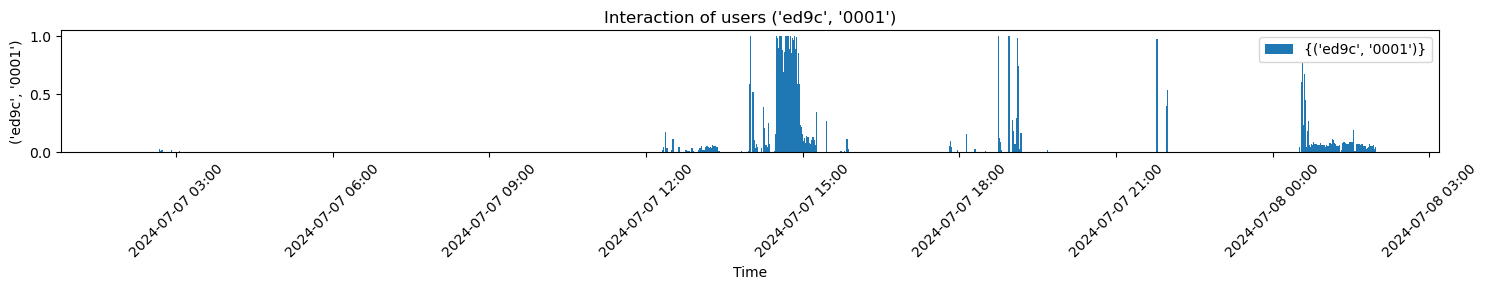

ed9c 3d57


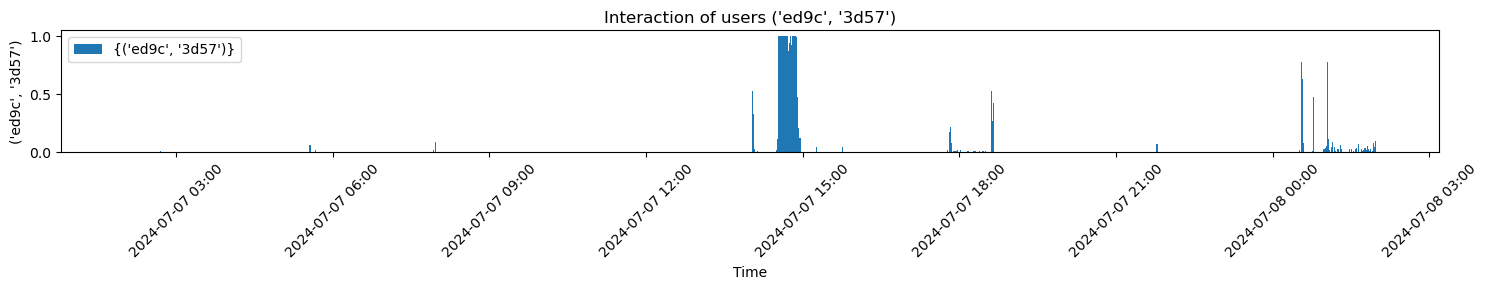

0001 3d57


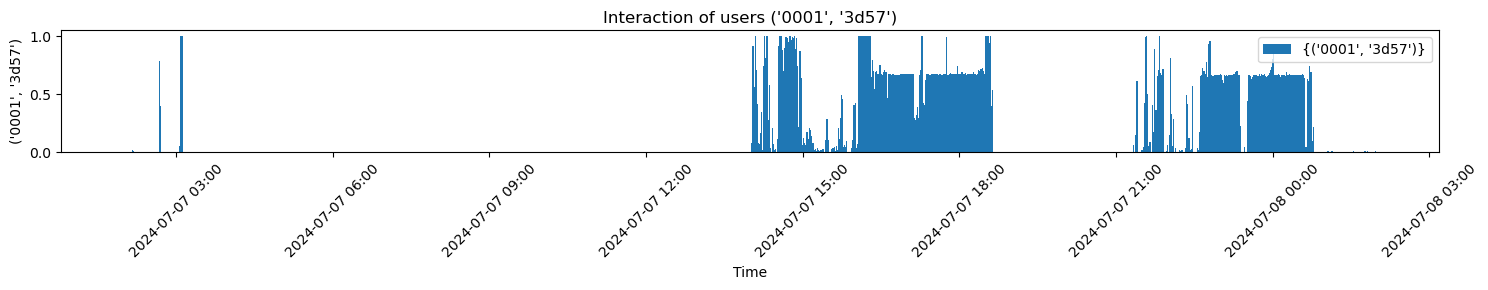

In [9]:
import matplotlib.pyplot as plt
from itertools import cycle
from IPython.core.display import display, HTML

from IPython.core.display import display, HTML

import matplotlib.dates as mdates

pairs = combinations(users, 2)

for pair in pairs:
    print(pair[0], pair[1])
    try:
        file_path = os.path.join(processed_data_folder+"DAY_"+str(day)+"/"+str(pair[0])+"."+str(pair[1])+".tsv")
        series = pd.read_csv(file_path, sep="\t", parse_dates=[0], header=None, names=["Timestamp", "Value"])

        series["Value"] = pd.to_numeric(series["Value"], errors='coerce')
        series.dropna(subset=["Value"], inplace=True)

        fig, ax = plt.subplots(figsize=(15, 3))
        ax.bar(series["Timestamp"], series["Value"], label={pair}, width=0.001)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        plt.xticks(rotation=45)

        ax.set_xlabel('Time')
        ax.set_ylabel(pair)
        ax.set_title(f"Interaction of users {pair}")
        ax.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print("No data for pair "+str(pair)+":"+str(e))